# CLIP-DINOiser visualization demo 🖼️

/opt/miniconda3/envs/clip_dinoiser/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/miniconda3/envs/clip_dinoiser/lib/python3.9/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Class embeddings shape:  torch.Size([21, 512])


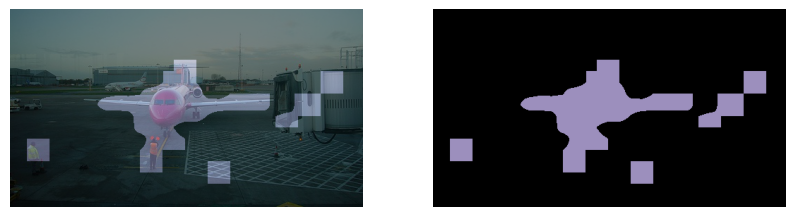

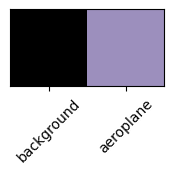

In [1]:
from hydra.core.global_hydra import GlobalHydra
import os
from models.builder import build_model
from helpers.visualization import mask2rgb
from segmentation.datasets import PascalVOCDataset
from hydra import compose, initialize
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms as T
import torch
import warnings
warnings.filterwarnings('ignore')
GlobalHydra.instance().clear()
initialize(config_path="configs", version_base=None)

def visualize_per_image(file_path, support_files, palette, model, class_names):
    # Assert that the main image exists
    assert os.path.isfile(file_path), f"No such file: {file_path}"
    
    # print(f"Dataset classes: {dataset_classes}")

    # Open and preprocess the main image
    img = Image.open(file_path).convert('RGB')
    img_tens = T.PILToTensor()(img).unsqueeze(0).to(device) / 255.

    # Load and preprocess support images
    support_images = []
    for support_file in support_files:
        assert os.path.isfile(support_file), f"No such file: {support_file}"
        support_img = Image.open(support_file).convert('RGB')

        # Resize the support images to match the size of the main image
        support_img_resized = support_img.resize(img.size, Image.BILINEAR)

        # Convert to tensor and normalize
        support_img_tens = T.PILToTensor()(support_img_resized).unsqueeze(0).to(device) / 255.
        support_images.append(support_img_tens)
    
    # Stack the support images into a batch
    support_images = torch.cat(support_images, dim=0).to(device)  
    # for spt in support_images:
    #     print(spt.shape)
    
    # Get the original height and width of the image
    h, w = img_tens.shape[-2:]
    merged = torch.cat((img_tens, support_images), dim=0)
    # print(f'merged: {merged.shape}')
    
    # Run the model for segmentation using both the main image and the support images
    output = model(merged).cpu()  # Ensure your model can accept both inputs
    output = F.interpolate(output, scale_factor=model.vit_patch_size, mode="bilinear", align_corners=False)[..., :h, :w]
    
    # Visualizza le probabilità per ogni classe
    # output[0] contiene le probabilità per ciascun pixel e ciascuna classe
    # output[0].shape sarà [C, H, W], dove C è il numero di classi
    
    # Itera su tutte le classi per stampare le probabilità
    # C, H, W = output[0].shape
    # for class_idx in range(C):
    #     class_probs = output[0][class_idx]
    #     print(f"Classe {class_idx}:")
    #     print(f"Probabilità media per classe {class_idx}: {class_probs.mean().item()}")
    #     print("-" * 50)
    
    output = output[0].argmax(dim=0)  # Get the most likely class for each pixel
    
    # Convert the output to an RGB mask using the provided palette
    mask = mask2rgb(output, palette)

    # Extract unique class indices from the output mask and map to the palette
    detected_classes = np.unique(output).tolist()
    # print(f"Detected classes (indices): {detected_classes}")

    # Filter out the classes that were not detected and print their names
    detected_class_names = [class_names[idx] for idx in detected_classes if idx < len(class_names)]
    # print(f"Detected class names: {detected_class_names}")

    # Create the visualization: segmented mask and original image
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    
    # Blending the original image with the mask for visualization
    alpha = 0.5
    blend = (alpha) * np.array(img) / 255. + (1 - alpha) * mask / 255.
    ax[0].imshow(blend)
    ax[0].axis('off')
    
    ax[1].imshow(mask)
    ax[1].axis('off')
    
    # Visualization of class colors along with support image file names as labels
    class_colors = np.array([palette[class_idx] for class_idx in detected_classes if class_idx < len(palette)])
    plt.figure(figsize=(6, 1))
    plt.imshow(class_colors.reshape(1, -1, 3))
    plt.xticks(np.arange(len(detected_class_names)), detected_class_names, rotation=45)
    plt.yticks([])

    return mask, fig, img

check_path = './checkpoints/last.pt'
check = torch.load(check_path, map_location='cpu')
dinoclip_cfg = "clip_dinoiser.yaml"
cfg = compose(config_name=dinoclip_cfg)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = build_model(cfg.model, class_names=PascalVOCDataset.CLASSES).to(device)
model.clip_backbone.decode_head.use_templates = False  # switching off the imagenet templates for fast inference
model.load_state_dict(check['model_state_dict'], strict=False)
model = model.eval()
# TEST WITH TWO SUPPORT IMAGES
file = 'assets/airplane.jpg'
support_files = ['assets/air2.jpg']  # Two support images

PALETTE = [(0, 0, 0), (156, 143, 189), (79, 158, 101)]

# Run segmentation with two support images, no text prompts required
model.apply_found = True  # assuming this flag is still relevant for your setup

# Lista dei nomi delle classi (questo esempio è per 3 classi)
class_names = ['background', 'aeroplane', 'bicycle']
# Run segmentation
mask, ticks, img = visualize_per_image(file, support_files, PALETTE, model, class_names)

# Evaluation

In [31]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
from datasets_custom import PascalVOCDataset # Import the PascalVOCDataset class


dinoclip_cfg = "clip_dinoiser.yaml"
cfg = compose(config_name=dinoclip_cfg)

def calculate_iou(pred, target, num_classes):
    ious = []
    pred = pred.view(-1)
    target = target.view(-1)
    for cls in range(num_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds[target_inds]).long().sum().item()
        union = pred_inds.long().sum().item() + target_inds.long().sum().item() - intersection
        if union == 0:
            ious.append(float('nan'))  # If there is no ground truth, do not include in evaluation
        else:
            ious.append(float(intersection) / max(union, 1))
    return np.array(ious)

def evaluate_model(model, dataloader, num_classes):
    model.eval()
    iou_list = []
    with torch.no_grad():
        for idx, data in enumerate(dataloader):
            images, targets = data
            images = images.to(device)
            targets = targets.to(device)
            outputs = model(images)
            outputs = F.interpolate(outputs, size=targets.shape[-2:], mode='bilinear', align_corners=False)
            preds = outputs.argmax(dim=1)
            ious = calculate_iou(preds, targets, num_classes)
            iou_list.append(ious)
            miou = np.nanmean(ious)
            print(f'Image {idx + 1} mIoU: {miou}')
    iou_list = np.array(iou_list)
    miou = np.nanmean(iou_list, axis=0)
    return miou


# Define the pipeline
pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(512, 512), keep_ratio=True),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='Normalize', mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True),
    dict(type='Pad', size_divisor=32),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg'])
]

# Path to the Pascal VOC dataset
img_dir = '/Users/micheleverriello/LabelAnything/data/pascal/JPEGImages'
ann_dir = '/Users/micheleverriello/LabelAnything/data/pascal/SegmentationClass'
split_file = '/Users/micheleverriello/LabelAnything/data/pascal/ImageSets/Segmentation/val.txt'

# Load the Pascal VOC dataset with a limit of 10 images
dataset = PascalVOCDataset(split=split_file, img_dir=img_dir, ann_dir=ann_dir, pipeline=pipeline, limit=1000)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=4)

# Calculate the mIoU
num_classes = len(PascalVOCDataset.CLASSES)
miou = evaluate_model(model, dataloader, num_classes)
print(f'mIoU: {np.nanmean(miou)}')

Image 1 mIoU: 0.6827867525535973
Image 2 mIoU: 0.1857632723721591
Image 3 mIoU: 0.28668856316304586
Image 4 mIoU: 0.1947443561300247
Image 5 mIoU: 0.1962907697899093
Image 6 mIoU: 0.6948706618015984
Image 7 mIoU: 0.2360907660590278
Image 8 mIoU: 0.2400315054115575
Image 9 mIoU: 0.19772120223802964
Image 10 mIoU: 0.426097044367521
Image 11 mIoU: 0.20189391662613998
Image 12 mIoU: 0.32192261038986786
Image 13 mIoU: 0.1945218172940341
Image 14 mIoU: 0.18247477213541666
Image 15 mIoU: 0.15997468512747526
Image 16 mIoU: 0.28180015611069803
Image 17 mIoU: 0.15859630032644179
Image 18 mIoU: 0.24595626308995835
Image 19 mIoU: 0.1823782055301273
Image 20 mIoU: 0.055990666135251055
Image 21 mIoU: 0.2487102991284185
Image 22 mIoU: 0.18894989055499867
Image 23 mIoU: 0.1021523444576513
Image 24 mIoU: 0.24795193142361113
Image 25 mIoU: 0.1935164087109019
Image 26 mIoU: 0.2664992028551974
Image 27 mIoU: 0.21424569516952588
Image 28 mIoU: 0.4757351345486111
Image 29 mIoU: 0.419083398122763
Image 30 mI